## **DATASET CREATION**

In [87]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from nltk.corpus import stopwords
from langdetect import detect
import re
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from langdetect import detect
import spacy
from tqdm import tqdm
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import os
import matplotlib.pyplot as plt
import little_mallet_wrapper as lmw

In [88]:
politicians= pd.read_csv('politicians_data/politicians_classified.csv')
politicians.drop(politicians.columns[-1], axis=1, inplace=True)

### Preprocessing

In [89]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load stopwords
stop_words_italian = set(stopwords.words('italian'))
stop_words_english = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Load spaCy models for Italian and English
# You need to install these models first using:
nlp_it = spacy.load('it_core_news_sm')
nlp_en = spacy.load('en_core_web_sm')

def preprocess_text(text):
    try:
        # Detect language
        lang = detect(text)
    except:
        lang = 'unknown'
    
    # Remove URLs, mentions, hashtags, and punctuation
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    
    if lang == 'it':  # Italian
        # Process with spaCy for Italian
        doc = nlp_it(text.lower())
        # Get lemmas and filter stopwords, short words, verbs, and adverbs
        true_tokens = [token.lemma_ for token in doc 
                      if token.text not in stop_words_italian and len(token.text) > 2 and token.pos_ not in ('VERB', 'ADV','AUX')]
    
    elif lang == 'en':  # English
        # Process with spaCy for English
        doc = nlp_en(text.lower())
        # Get lemmas and filter stopwords, short words, verbs, and adverbs
        true_tokens = [token.lemma_ for token in doc 
                      if token.text not in stop_words_english and len(token.text) > 2 and token.pos_ not in ('VERB', 'ADV')]
    
    else: 
        # Fallback to NLTK for spacy errors or mislablings
        tokens = word_tokenize(text.lower())
        true_tokens = [lemmatizer.lemmatize(word) for word in tokens if len(word) > 2]
    
    return true_tokens

# Apply preprocessing to the tweets
politicians_tweets = politicians['Content']

# Method 1: Using tqdm with apply (simpler)
tqdm.pandas(desc="Processing tweets")
politicians['processed_tweet'] = politicians_tweets.progress_apply(lambda x: preprocess_text(x))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/filippofocaccia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/filippofocaccia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/filippofocaccia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Processing tweets: 100%|██████████| 17245/17245 [03:37<00:00, 79.25it/s]


### We divide the politicians in separate datasets with respect to their belief and perform topic modeling using gensim LDA and the and the little MALLET wrapper LDA topic modeling https://github.com/maria-antoniak/little-mallet-wrapper/blob/master/demo.ipynb

### The difference across these two approaches is the following: Gensim typically uses Variational Bayes, which is a different approach compared to MALLET's Gibbs sampling.

### Let's start with the right wing politicians and the gensim LDA approach

In [90]:
right_wing=politicians[politicians['ideology_num'] == 3]
right_wing_processed = right_wing['processed_tweet']
dictionary_right = corpora.Dictionary(right_wing['processed_tweet'])
corpus_right = [dictionary_right.doc2bow(text) for text in right_wing['processed_tweet']]

### We explore which is the best number of topics by computing coherence scores for each LDA model

In [91]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model =LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [92]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary_right, corpus=corpus_right, texts=right_wing_processed, start=3, limit=45, step=3)

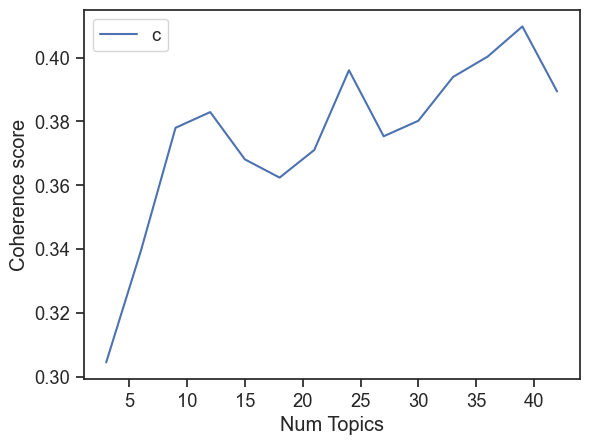

In [93]:
limit=45; start=3; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Let's see now the topics obtained from the LDA model with the optimal number of topics

In [94]:
x_list= list(x)
best_num_topics_right_lda = x_list[np.argmax(coherence_values)]
lda_model_right= LdaModel(corpus=corpus_right, id2word=dictionary_right, num_topics=best_num_topics_right_lda, passes=10, random_state=42)
for idx, topic in lda_model_right.print_topics(-1):
    print(f"Topic {idx}: {topic}")

Topic 0: 0.050*"paura" + 0.026*"bravo" + 0.025*"infrastruttura" + 0.024*"conto" + 0.021*"ragazzo" + 0.021*"trasporto" + 0.020*"dialogo" + 0.017*"associazione" + 0.015*"premier" + 0.015*"strage"
Topic 1: 0.050*"qualche" + 0.041*"disabilità" + 0.032*"giornata" + 0.031*"opera" + 0.027*"generale" + 0.020*"napolo" + 0.019*"figliuolo" + 0.015*"maggio" + 0.015*"europe" + 0.014*"gennaio"
Topic 2: 0.074*"libero" + 0.060*"firma" + 0.035*"droga" + 0.034*"figlio" + 0.027*"danno" + 0.027*"comune" + 0.021*"5stelle" + 0.021*"genitore" + 0.019*"leader" + 0.018*"base"
Topic 3: 0.079*"lavoro" + 0.031*"cittadinanza" + 0.026*"italiano" + 0.023*"buono" + 0.022*"reddito" + 0.020*"senza" + 0.019*"salute" + 0.018*"sud" + 0.016*"nuovo" + 0.016*"governo"
Topic 4: 0.044*"anno" + 0.029*"via" + 0.026*"polizia" + 0.021*"tax" + 0.021*"partita" + 0.021*"flat" + 0.017*"giustizia" + 0.017*"agente" + 0.016*"complimento" + 0.016*"giovane"
Topic 5: 0.054*"militare" + 0.044*"camera" + 0.040*"diretta" + 0.039*"dellitalio" +

### Let's see a representation of the topics

In [95]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath_right = os.path.join('./results/ldavis_prepared_right'+str(best_num_topics_right_lda))

if 1 == 1:
    LDAvis_prepared_right = gensimvis.prepare(lda_model_right, corpus_right, dictionary_right)
    with open(LDAvis_data_filepath_right, 'wb') as f:
        pickle.dump(LDAvis_prepared_right, f)

with open(LDAvis_data_filepath_right, 'rb') as f:
    LDAvis_prepared_right = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared_right, './results/ldavis_prepared_right'+ str(best_num_topics_right_lda) +'.html')

LDAvis_prepared_right

/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/cor

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
31    -0.227315  0.039217       1        1  4.807223
8     -0.176495  0.130519       2        1  4.718088
11    -0.149423 -0.151895       3        1  4.265404
16    -0.160246  0.109801       4        1  4.154274
6     -0.119499 -0.153259       5        1  3.819613
3     -0.161713 -0.043914       6        1  3.653425
27    -0.131255 -0.147587       7        1  3.522531
15    -0.097389  0.138720       8        1  3.029342
18    -0.108132 -0.077656       9        1  3.009988
23     0.040078  0.005085      10        1  2.963990
19    -0.031386  0.030614      11        1  2.911001
33    -0.074192  0.002806      12        1  2.880366
32    -0.048560 -0.093512      13        1  2.878898
20     0.008554  0.179934      14        1  2.878532
12     0.056699  0.020641      15        1  2.836111
28    -0.084706 -0.137950      16        1  2.774276
4      0.068672 -0.075413      17        1  2.660309
24    -0.041415  0.044201      18        1  2.588877
29     0.095486 -0.081017      19        1  2.459706
34    -0.017411  0.126000      20        1  2.413832
14    -0.065691  0.146890      21        1  2.370161
13     0.010845 -0.010536      22        1  2.219404
22     0.029697  0.037505      23        1  2.144430
30     0.026917 -0.003910      24        1  2.063840
36     0.008955  0.085406      25        1  2.025401
10     0.072504 -0.033701      26        1  2.021579
25     0.027635  0.019104      27        1  1.997929
2      0.112246 -0.014125      28        1  1.890070
26     0.057123 -0.037586      29        1  1.884253
0      0.063510  0.028198      30        1  1.877518
9      0.091848 -0.007503      31        1  1.793678
37     0.026376 -0.086867      32        1  1.755789
1      0.182583  0.020216      33        1  1.698580
38     0.124448 -0.030274      34        1  1.686672
35     0.074088  0.003410      35        1  1.670495
17     0.118816 -0.036127      36        1  1.541413
7      0.074700  0.050685      37        1  1.540048
21     0.133414 -0.010053      38        1  1.533483
5      0.189634  0.013935      39        1  1.059471, topic_info=            Term        Freq       Total Category  logprob  loglift
1960        lega  680.000000  680.000000  Default  30.0000  30.0000
298       lavoro  794.000000  794.000000  Default  29.0000  29.0000
212     ministro  448.000000  448.000000  Default  28.0000  28.0000
22          Roma  280.000000  280.000000  Default  27.0000  27.0000
530       parola  265.000000  265.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1572      attimo    5.002305    6.009455  Topic39  -5.3935   4.3640
4     government   10.673587   14.037641  Topic39  -4.6356   4.2734
470       dramma   13.544780   18.351566  Topic39  -4.3974   4.2437
1693       amore    9.287129   14.749883  Topic39  -4.7748   4.0848
1463      solito   11.360465   21.809272  Topic39  -4.5733   3.8952

[2041 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1133      1  0.333044  \n\n 
1133     25  0.646496  \n\n 
5564     31  0.933671  \n \n
1523     30  0.946518   \n\n
5075     21  0.132759    \n 
...     ...       ...    ...
2986     30  0.837245    zio
2119      5  0.438922   zona
2119     15  0.307246   zona
2119     24  0.073154   zona
2119     31  0.175569   zona

[3979 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[32, 9, 12, 17, 7, 4, 28, 16, 19, 24, 20, 34, 33, 21, 13, 29, 5, 25, 30, 35, 15, 14, 23, 31, 37, 11, 26, 3, 27, 1, 10, 38, 2, 39, 36, 18, 8, 22, 6])

### (OLD) Topics:
- Topic 0: "Traditional Family Values": 
    This topic centers around family, women, solidarity, life, and education. The prominence of words like "famiglia" (family), "donna" (woman), "vita" (life), and "solidarietà" (solidarity) suggests a focus on traditional social values and family structures. The appearance of "scuola" (school) indicates emphasis on education within this traditional values framework.


- Topic 1: "National Identity and Immigration"
    This topic features words related to national identity and immigration concerns. Key terms include "italiano" (Italian), "sinistra" (left/left-wing), "paese" (country), "libertà" (freedom), "Italia" (Italy), and importantly "clandestino" (illegal immigrant). This suggests rhetoric focused on opposition to immigration, criticism of left-wing policies, and emphasis on national sovereignty and Italian identity.


- Topic 2: "Economic Governance and Center-Right Coalition":
    This topic revolves around governance and economic issues. Prominent words include "governo" (government), "lavoro" (work), "impresa" (business/enterprise), "presidente" (president), "centrodestra" (center-right), and "drago" (possibly referring to Mario Draghi). This suggests rhetoric focused on economic policy, business interests, and center-right governance.

### Let's see now which topic is assigned to each tweet 

In [97]:
def format_topics_sentences(ldamodel, corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel.get_document_topics(corpus)):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = pd.concat([sent_topics_df, pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]], columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])], ignore_index=True)
            else:
                break

    # Add original text to the end of the output
    return sent_topics_df


In [98]:
f_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_right, corpus=corpus_right)

# Format
df_dominant_topic = f_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,0,1,0.3662,"qualche, disabilità, giornata, opera, generale..."
1,1,24,0.6597,"alto, partito, testa, vivo, regola, dellitalia..."
2,2,15,0.4553,"amico, futuro, italiano, storia, paese, cultur..."
3,3,9,0.4369,"notizia, attacco, tutela, gesto, cristiano, co..."
4,4,12,0.4971,"due, violenza, solidarietà, grave, tutto, anno..."
5,5,1,0.8782,"qualche, disabilità, giornata, opera, generale..."
6,6,1,0.9250,"qualche, disabilità, giornata, opera, generale..."
7,7,4,0.4301,"anno, via, polizia, tax, partita, flat, giusti..."
8,8,21,0.6263,"pieno, vicinanza, splendido, dipendente, raggi..."
9,9,1,0.5587,"qualche, disabilità, giornata, opera, generale..."


### Let's approach now the task with the LDA implementation in the MALLLET wrapper

In [99]:
MALLET_path= '/opt/local/bin/mallet'
output_directory = '/Users/filippofocaccia/Desktop/nlp-project/politicians_data/politicians_filtered'
right_wing['processed_tweet_MALLET']=right_wing['processed_tweet'].apply(lambda x: ' '.join(x))
data_mallet= [t for t in right_wing['processed_tweet_MALLET'].tolist()]
data_mallet= [t for t in data_mallet if t.strip()]

/var/folders/9d/sqxp5kj56832p1mf59mk01gc0000gn/T/ipykernel_67908/4211438610.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_wing['processed_tweet_MALLET']=right_wing['processed_tweet'].apply(lambda x: ' '.join(x))


### Let's find the optimal number of topics

In [100]:
def calculate_coherence(topic_keys, training_data, coherence_type='c_v', top_n=10):
    """
    Calculate topic coherence using Gensim's CoherenceModel.
    
    Parameters:
    - topic_keys: List of topic keywords per topic from MALLET
    - training_data: List of tokenized documents
    - coherence_type: Type of coherence to calculate ('c_v', 'u_mass', 'c_uci', or 'c_npmi')
    - top_n: Number of top words to consider
    
    Returns:
    - Average coherence score
    - List of coherence scores per topic (if available)
    """
    # Prepare the tokenized texts
    tokenized_texts = [doc.split() for doc in training_data]
    
    # Create Gensim dictionary
    dictionary = Dictionary(tokenized_texts)
    
    # Prepare topic words (limiting to top_n)
    topics_list = [[word for word in topic[:top_n]] for topic in topic_keys]
    
    # Create coherence model
    coherence_model = CoherenceModel(
        topics=topics_list,
        texts=tokenized_texts,
        dictionary=dictionary,
        coherence=coherence_type
    )
    
    # Calculate and return coherence
    coherence_score = coherence_model.get_coherence()
    
    # For some coherence types, we can get per-topic coherence
    try:
        topic_coherences = coherence_model.get_coherence_per_topic()
    except:
        # Not all coherence types support per-topic coherence
        topic_coherences = [coherence_score] * len(topics_list)
    
    return coherence_score, topic_coherences

In [101]:

def find_optimal_topics(path_to_mallet, output_directory_path, training_data, 
                              topic_range=(5, 50, 5), coherence_type='c_v', top_n=10):
    """
    Find the optimal number of topics using Gensim's coherence measures.
    
    Parameters:
    - path_to_mallet: Path to MALLET executable
    - output_directory_path: Directory to save output files
    - training_data: List of tokenized documents
    - topic_range: Tuple of (start, end, step) for number of topics to try
    - coherence_type: Coherence measure to use
    - top_n: Number of top words to consider
    
    Returns:
    - List of number of topics
    - List of corresponding coherence scores
    """
    # Initialize lists to store results
    num_topics_list = list(range(topic_range[0], topic_range[1] + 1, topic_range[2]))
    coherence_scores = []

    # Create training data file once
    path_to_training_data = output_directory_path + '/coherence_training.txt'
    
    # Import data once
    lmw.import_data(path_to_mallet,
                   path_to_training_data,
                   output_directory_path + '/coherence.training',
                   training_data)
    
    # Train models with different numbers of topics
    for num_topics in num_topics_list:
        # Create output directory for this number of topics
        output_directory_num = os.path.join(output_directory_path, str(num_topics))
        if not os.path.exists(output_directory_num):
            os.mkdir(output_directory_num)
            output_directory_path_num = output_directory_num
        else:
            output_directory_path_num = output_directory_num
        print(f"Training model with {num_topics} topics...")
        
        # Train the model
        topic_keys, _ = lmw.quick_train_topic_model(path_to_mallet,
                             output_directory_path_num,
                            num_topics,
                            training_data)
        
        # Calculate coherence using Gensim
        coherence_score, _ = calculate_coherence(
topic_keys, training_data, coherence_type, top_n)
        
        coherence_scores.append(coherence_score)
        print(f"Number of topics: {num_topics}, {coherence_type.upper()} Coherence: {coherence_score:.4f}")
    
    return num_topics_list, coherence_scores


In [102]:
num_topics_list, coherence_scores = find_optimal_topics(
    MALLET_path,
    output_directory,
    data_mallet,
    topic_range=(3, 40, 5),
    coherence_type='c_v',
    top_n=10
)


Importing data...
Complete
Training model with 3 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 3 topics, 2 topic bits, 11 topic mask
Data loaded.
max tokens: 30
total tokens: 102673
<10> LL/token: -8,90171
<20> LL/token: -8,74522
<30> LL/token: -8,65648
<40> LL/token: -8,60924

0	1,66667	Italia europeo forza paese presidente grande centrodestra grazie lavoro litalia politico governo italiano Roma tutto mondo libertà centro amico democrazia 
1	1,66667	governo italiano sinistra ministro altro anno senza casa milione tempo scuola dopo persona mentre sicurezza paese drago parola partito cittadino 
2	1,66667	famiglia impresa italiano lega lavoro anno vita governo donna tassa proposta pace stato parte primo giovane solidarietà tutto uomo giustizia 

<50> LL/token: -8,57727
<60> LL/token: -8,55876
<70> LL/token: -8,53823
<80> LL/token: -8,52182
<90> LL/token: -8,51391

0	1,66667	paese lavoro Italia europeo forza presidente grande grazie centrodestra governo politico tutto cittadino Roma litalia italiano mondo futuro buono sindaco 
1	1,66667	governo italiano sinistra altro m

Complete
Number of topics: 3, C_V Coherence: 0.4703
Training model with 8 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 8 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 30
total tokens: 102673
<10> LL/token: -9,19512
<20> LL/token: -8,90854
<30> LL/token: -8,78285
<40> LL/token: -8,71507

0	0,625	europeo Italia paese litalia mondo futuro Europa crisi politica grande forza sicuro nazionale tema cittadino lavoro energetico governo forte nuovo 
1	0,625	grazie italiano ministro lega persona clandestino Italia lamorgese confine sbarco settembre settembrevotolega referendumgiustizia sicurezza paese tanto libertà processo libero altro 
2	0,625	Roma sinistra tutto solidarietà città sindaco nazione minaccia pensiero centro certo casa candidato morte bravo responsabile umano atto pieno modello 
3	0,625	lavoro governo tassa impresa italiano lavoratore lega nuovo famiglia casa fiscale euro milione pace riforma sostegno anno cittadinanza proposta mila 
4	0,625	italiano governo centrodestra presidente sinistra litalia politico partito cosa voto elezione salvino paese altro pronto anno lunic

Complete
Number of topics: 8, C_V Coherence: 0.5710
Training model with 13 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 13 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 30
total tokens: 102673
<10> LL/token: -9,31774
<20> LL/token: -8,99901
<30> LL/token: -8,86515
<40> LL/token: -8,79453

0	0,38462	paese litalia futuro politica europeo Italia ministro confine sbarco clandestino sinistra nucleare sicuro punto primo tema dellitalia nuovo sviluppo ultimo 
1	0,38462	lavoro tassa nuovo fiscale legge lega giovane lavoratore casa proposta pace solo elettorale riforma pensione grazie patrimoniale buono impresa flat 
2	0,38462	forza centrodestra presidente politico governo partito Italia valore grande elezione europeo nazione prossimo repubblica voto parlamento importante forte programma progetto 
3	0,38462	impresa lavoro famiglia europeo tempo bolletta gas luce caro costo fondo priorità vaccinale proposta emergenza stato commissione posto cittadino lega 
4	0,38462	anno ogni amico grazie tutto vita referendumgiustizia giorno firma tanto libertà persona Italia buono piazza bambino bim

Complete
Number of topics: 13, C_V Coherence: 0.5895
Training model with 18 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 18 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 30
total tokens: 102673
<10> LL/token: -9,38047
<20> LL/token: -9,0438
<30> LL/token: -8,89261
<40> LL/token: -8,81489

0	0,27778	lavoro lavoratore stato primo diritto europeo sostegno importante posto impresa parte aiuto miliardo follia fondo modo pensione buono difesa molto 
1	0,27778	sinistra libertà altro ogni parola senza notizia libero tempo giornalista italiano verità alcuno insulto parlamentare qualche secondo due cosa vicenda 
2	0,27778	tassa fiscale nuovo pace famiglia italiano Italia cartella nucleare giustizia futuro riforma sicuro anno senza ultimo taglio giusto esattoriale sfida 
3	0,27778	governo europeo drago vaccino presidente paese intervista passo lavoro piano vaccinale salute proposta stato commissione salvino primo nazionale cittadino cambio 
4	0,27778	impresa famiglia governo caro economico gas bolletta lega crisi luce proposta difficoltà priorità costo italiano concreto primo aumento d

Complete
Number of topics: 18, C_V Coherence: 0.5193
Training model with 23 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 23 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 30
total tokens: 102673
<10> LL/token: -9,47548
<20> LL/token: -9,1033
<30> LL/token: -8,9455
<40> LL/token: -8,86433

0	0,21739	governo italiano parlamento cittadino conte maggioranza voto tempo fiducia coprifuoco misura poltrona nazione intervista drago senato giorno parte ditalia altro 
1	0,21739	tassa lavoro lega proposta nuovo legge primo casa nucleare italiano pensione sicuro energia imprenditore settembre miliardo sostegno taglio generazione settembrevotolega 
2	0,21739	italy gioco destra europe thank common cooperation bilateral meeting european freedom challenge strong palazzo fuoco people relation regime must energy 
3	0,21739	lavoro sicurezza lavoratore impresa milione attività pubblico riapertura cartella salute scuola governo italiano vaccinale ritorno fiscale ministro esattoriale salvino chiusura 
4	0,21739	lega grazie sindaco Roma tanto dopo bello città anno persona cittadino tax flat comunità

Complete
Number of topics: 23, C_V Coherence: 0.5647
Training model with 28 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 28 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 30
total tokens: 102673
<10> LL/token: -9,48672
<20> LL/token: -9,12067
<30> LL/token: -8,97505
<40> LL/token: -8,90251

0	0,17857	cittadinanza reddito italy europe thank common cooperation bilateral furbetto european freedom challenge strong facile soldo people relation leader must energy 
1	0,17857	persona parola sindaco lega guerra candidato minaccia enrico fatto alto pace disabilità solidarietà qualche regione parte squadra mattina porta limpegno 
2	0,17857	Italia sicurezza forza lavoro tutto governo strada stato tempo danno mondo necessario cittadino presenza leuropa priorità risorsa nazionale ponte problema 
3	0,17857	governo litalia italiano paese testa alto fiducia cosa parte parlamento cittadino popolo giornalista nazionale fondamentale forte confronto progetto Russia stato 
4	0,17857	presidente drago governo repubblica partito italiano tema parlamento salvino senato consiglio politica scelta propos

Complete
Number of topics: 28, C_V Coherence: 0.5834
Training model with 33 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 33 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 30
total tokens: 102673
<10> LL/token: -9,53532
<20> LL/token: -9,15591
<30> LL/token: -8,99917
<40> LL/token: -8,91583

0	0,15152	governo stato italiano senato presidente crisi responsabilità conte cittadino litalia popolo paese volta maggioranza capo momento europeo economico nazione pronto 
1	0,15152	forza grande nuovo Milano grazie sinistra città pronto politico strada sicuro importante crescita ponte bilancio sindaco progetto competenza momento allitalio 
2	0,15152	ministro clandestino sbarco lamorgese confine litalia italiano paese altro immigrato sicurezza dellinterno settembre illegale limmigrazione mentre dovere ong regola processo 
3	0,15152	cosa italiano politica nessuno altro confronto parte amico modo tanto diverso sede intervento palazzo modello lunico nuovo buono partito berluscone 
4	0,15152	tassa casa legge italiano lega fiscale pensione giovane taglio aumento riforma settembrevotolega patr

Complete
Number of topics: 33, C_V Coherence: 0.5883
Training model with 38 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 38 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 30
total tokens: 102673
<10> LL/token: -9,60738
<20> LL/token: -9,21946
<30> LL/token: -9,05009
<40> LL/token: -8,96102

0	0,13158	vaccino economico covid cittadino sanitario rischio punto situazione turismo greenpass attività strumento pandemia necessario danno europeo azienda vaccinale vista sociale 
1	0,13158	ministro lamorgese clandestino sbarco confine immigrato litalia dellinterno Italia processo immigrazione senza ong limmigrazione illegale caso mentre campo viminale porto 
2	0,13158	anno bimbo mamma ragazzo bambino morte papà impegno nessuno fatto proprio richiesta signore discriminazione grado interno diritto politica partenza natale 
3	0,13158	solidarietà violenza stato ditalia giustizia fratello donna uomo criminale memoria minaccia Milano mafia verità giudice massimo episodio coraggio criminalità aggressione 
4	0,13158	sinistra settembre italiano settembrevotolega lega litalia idea voto programm

Complete
Number of topics: 38, C_V Coherence: 0.5650


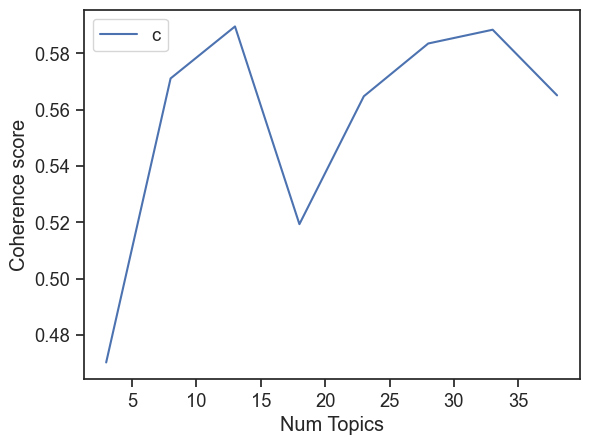

In [103]:
plt.plot(num_topics_list, coherence_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_scores"), loc='best')
plt.show()

### We now compute the LDA MALLET model with the optimal number of topics

In [104]:
best_num_topics_MALLET_right= num_topics_list[coherence_scores.index(max(coherence_scores))]
topic_keys, topic_distributions = lmw.quick_train_topic_model(MALLET_path, 
                                                              output_directory, 
                                                              best_num_topics_MALLET_right, 
                                                              data_mallet)

Importing data...
Complete
Training topic model...


Mallet LDA: 13 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 30
total tokens: 102673
<10> LL/token: -9,32031
<20> LL/token: -8,99566
<30> LL/token: -8,86372
<40> LL/token: -8,79445

0	0,38462	anno governo italiano dopo litalia volta quando problema danno risultato quello parlamento nazione fine momento mese stesso giorno due situazione 
1	0,38462	famiglia impresa lega gas governo mila bolletta miliardo difficoltà euro caro primo luce sostegno costo economico proposta crisi stato concreto 
2	0,38462	libertà diritto italiano democrazia persona presidente mondo tutto umano buono repubblica popolo amico parlamento elezione prossimo nome storia difesa vivo 
3	0,38462	forza Italia tutto vita solidarietà anno politico stato preghiera famiglia proprio vittima pensiero due polizia coraggio responsabile servizio carcere alcuno 
4	0,38462	ogni anno pace giorno ragazzo cartella violenza dopo guerra esattoriale lotta impegno solo sicurezza qualche senato stop leader tempo militare 

Complete


In [105]:
for i, t in enumerate(topic_keys):
    print(i, '\t', ' '.join(t))


0 	 governo italiano conte speranza cittadino misura altro grave sinistra gestione ministro tempo coprifuoco nulla pandemia drago senatore responsabilità dopo covid
1 	 impresa famiglia governo bolletta lega gas luce italiano cartella euro miliardo sostegno crisi costo difficoltà primo fiscale caro economico milione
2 	 libertà diritto democrazia mondo donna valore islamico parte pace violenza stato ogni storia libero italiano comunità militare popolo cristiano Israele
3 	 anno vita famiglia vittima giustizia donna italiano uomo preghiera giorno grazie tutto solidarietà pena caro senza memoria abbraccio figlio due
4 	 forza Milano donna sicurezza polizia città uomo solidarietà giorno agente servizio Roma due ragazzo strada carabiniere sindaco poliziotto violenza italiano
5 	 europe thank italy common cooperation bilateral european freedom challenge strong people relation must energy value president ready today government ukraine
6 	 ministro clandestino confine sbarco lamorgese italian

1. Security, Law and Order, and Immigration (Topics 4, 6, 10)
    This theme focuses on security concerns, immigration control, and law enforcement:
    Border control and immigration: Strong emphasis on unauthorized immigration ("clandestino," "sbarco," "immigrato," "illegale," "confine") with criticism of the Interior Minister Lamorgese's handling of immigration.
    Law enforcement: Frequent mentions of police forces ("polizia," "carabiniere," "agente") and security services ("sicurezza," "servizio").
    Urban safety: Focus on city security issues ("città," "strada") particularly in major cities like Milan and Rome.
    Political framing: Immigration and security issues are often positioned against the left ("sinistra") with rhetoric about threats ("minaccia") and calls for voter mobilization ("settembrevotolega").
    The discourse presents immigration as a security threat requiring stricter controls, while expressing strong support for law enforcement institutions and personnel, positioning these concerns in opposition to left-wing policies.

2. Economic Support for Businesses and Families (Topics 1, 8, 9)
    This theme addresses economic concerns with a focus on tax relief and business support:
    Energy costs and household expenses: Significant attention to utility bills ("bolletta," "gas," "luce"), costs of living, and financial difficulties facing families.
    Business and workers: Support for enterprises ("impresa") and workers ("lavoratore") with proposals for tax reductions ("tassa") and economic relief.
    Fiscal reform: Focus on tax documents ("cartella") and fiscal systems, suggesting reform policies to reduce tax burden.
    Economic recovery: Discussion of recovery planning, with references to millions and billions of euros in support measures.
    The discourse emphasizes alleviating financial pressures on families and businesses, particularly through tax reductions and government support during crisis periods, with specific attention to energy costs.
    
3. Traditional Values, Family, and Criticism of Government (Topics 0, 2, 3, 11)
    This theme centers on traditional values, family, and opposition to the current government:
    Family and traditional values: Strong emphasis on family ("famiglia"), religious references ("preghiera," "cristiano"), and traditional values with references to victims ("vittima") and solidarity ("solidarietà").
    Government criticism: Direct criticism of specific government figures like Conte and Speranza, especially regarding pandemic measures ("coprifuoco," "covid," "pandemia").
    Cultural identity: References to religious and cultural values ("valore," "cristiano," "Israele") in opposition to Islamic influence ("islamico").
    Liberty and rights: Framing issues in terms of freedom ("libertà"), rights ("diritto"), and democracy, often positioned against perceived restrictions.
    The discourse combines defense of traditional values and family with criticism of left-wing governance, presenting right-wing politics as defenders of fundamental freedoms and traditional cultural identities against perceived threats.

### We are now curious to see the contribution of each tweet to the topic like we did in the first approach

In [106]:
def format_topics_documents(topic_distributions, topic_keys, training_data, docs_metadata=None):
    """
    Format the dominant topic for each document in a DataFrame.
    
    Parameters:
    - topic_distributions: The topic distributions from MALLET (from lmw.load_topic_distributions)
    - topic_keys: The topic keywords from MALLET (from lmw.load_topic_keys)
    - training_data: Original documents (for displaying sample text)
    - docs_metadata: Optional metadata for each document (e.g., tweet ID, author, date)
    
    Returns:
    - DataFrame with dominant topic, contribution percentage, and keywords for each document
    """
    # Create a DataFrame for the results
    docs_topics_df = pd.DataFrame()
    
    # Process each document
    for i, doc_topics in enumerate(topic_distributions):
        if i== len(training_data):
            break
        # Find the dominant topic (highest probability)
        dominant_topic_idx = np.argmax(doc_topics)
        dominant_topic_contribution = doc_topics[dominant_topic_idx]
        
        # Get the keywords for this topic
        dominant_topic_keywords = ", ".join(topic_keys[dominant_topic_idx][:10])
        # Create a row for this document
        doc_row = pd.DataFrame({
            'Document_ID': i,
            'Dominant_Topic': int(dominant_topic_idx),
            'Topic_Perc_Contribution': round(dominant_topic_contribution, 4),
            'Topic_Keywords': dominant_topic_keywords,
            'Text_Sample': training_data[i] 
        }, index=[0])
        
        # Add metadata if provided
        if docs_metadata is not None and i < len(docs_metadata):
            for key, value in docs_metadata[i].items():
                doc_row[key] = value
        
        # Append to the results DataFrame
        docs_topics_df = pd.concat([docs_topics_df, doc_row], ignore_index=True)
    
    # Reorder columns if metadata was added
    cols = ['Document_ID', 'Dominant_Topic', 'Topic_Perc_Contribution', 'Topic_Keywords', 'Text_Sample']
    if docs_metadata is not None and len(docs_metadata) > 0:
        metadata_cols = list(docs_metadata[0].keys())
        cols = ['Document_ID'] + metadata_cols + ['Dominant_Topic', 'Topic_Perc_Contribution', 'Topic_Keywords', 'Text_Sample']
    
    # Ensure all expected columns exist
    existing_cols = [col for col in cols if col in docs_topics_df.columns]
    docs_topics_df = docs_topics_df[existing_cols]
    
    return docs_topics_df

In [107]:
tweets_topics_df_right = format_topics_documents(topic_distributions, topic_keys, data_mallet, docs_metadata=None)
tweets_topics_df_right.head(10)

,Document_ID,Dominant_Topic,Topic_Perc_Contribution,Topic_Keywords,Text_Sample
0,0,5,0.9112,"europe, thank, italy, common, cooperation, bil...",congratulation formation new government bilate...
1,1,11,0.7675,"governo, italiano, centrodestra, presidente, s...",nazione lottimismo lorgoglio unitalia fianco t...
2,2,12,0.5045,"europeo, paese, litalia, nucleare, difesa, pol...",conversazione telefonico sostegno governo ital...
3,3,3,0.5051,"anno, vita, famiglia, vittima, giustizia, donn...",uomo garbato intelligente servitore istituzion...
4,4,2,0.7030,"libertà, diritto, democrazia, mondo, donna, va...",libertà religioso obiettivo governo viaggio ir...
5,5,5,0.6273,"europe, thank, italy, common, cooperation, bil...",grazie kurdistan region safety citizen economi...
6,6,5,0.8478,"europe, thank, italy, common, cooperation, bil...",warm welcome erbil today iraq kurdistan region...
7,7,12,0.3933,"europeo, paese, litalia, nucleare, difesa, pol...",prezzo gas calo livello precedente linvasione ...
8,8,5,0.9390,"europe, thank, italy, common, cooperation, bil...",great pleasure speaker iraqi parliament today ...
9,9,5,0.8914,"europe, thank, italy, common, cooperation, bil...",great pleasure eager bilateral relation cooper...


### Let's now proceed with left wing politicians, we will do the same analysis done before appying LDA topic modeling from the two different packages

In [108]:
left_wing=politicians[politicians['ideology_num'] == 0]
left_wing_processed = left_wing['processed_tweet']
dictionary_left = corpora.Dictionary(left_wing['processed_tweet'])
corpus_left = [dictionary_left.doc2bow(text) for text in left_wing['processed_tweet']]

### We compute the the coherence to find the optimal number of topics for the LDA model

In [109]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary_left, corpus=corpus_left, texts=left_wing_processed, start=3, limit=45, step=3)

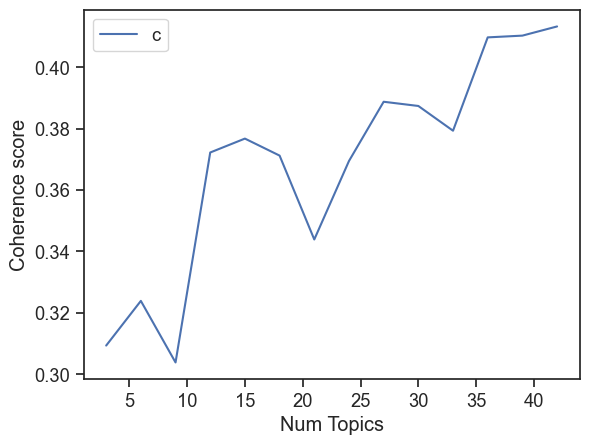

In [110]:
limit=45; start=3; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### We now can compute the gensim LDA model with the optimal number of topics

In [111]:
x_list= list(x)
best_num_topics_left_lda = x_list[np.argmax(coherence_values)]
lda_model_left = LdaModel(corpus=corpus_left, id2word=dictionary_left, num_topics=best_num_topics_left_lda, passes=10, random_state=42)
# 6. Stampa dei topic
for idx, topic in lda_model_left.print_topics(-1):
    print(f"Topic {idx}: {topic}")


Topic 0: 0.097*"candidato" + 0.047*"libero" + 0.029*"paura" + 0.023*"efficace" + 0.023*"sovranista" + 0.018*"forte" + 0.018*"scelta" + 0.017*"centrale" + 0.016*"comunale" + 0.015*"unità"
Topic 1: 0.047*"ciò" + 0.042*"voto" + 0.036*"elettore" + 0.035*"lega" + 0.034*"coalizione" + 0.028*"responsabilità" + 0.027*"fascismo" + 0.025*"stampa" + 0.025*"governo" + 0.025*"destra"
Topic 2: 0.092*"quando" + 0.081*"conte" + 0.058*"mese" + 0.033*"nulla" + 0.031*"dopo" + 0.029*"governo" + 0.025*"elezione" + 0.023*"cosa" + 0.021*"chiaro" + 0.020*"unico"
Topic 3: 0.082*"momento" + 0.042*"senso" + 0.031*"investimento" + 0.026*"mercato" + 0.023*"paese" + 0.019*"settembre" + 0.018*"sud" + 0.018*"grande" + 0.017*"strumento" + 0.016*"difficoltà"
Topic 4: 0.075*"donna" + 0.054*"solidarietà" + 0.037*"vittima" + 0.035*"violenza" + 0.028*"uomo" + 0.024*"drammatico" + 0.023*"pieno" + 0.022*"bambino" + 0.021*"regime" + 0.020*"senza"
Topic 5: 0.049*"storia" + 0.048*"covid19" + 0.044*"comune" + 0.039*"ultimo" + 0.

### Let's see a representation of our topics

In [112]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_left'+str(best_num_topics_left_lda))

if 1 == 1:
    LDAvis_prepared_left = gensimvis.prepare(lda_model_left, corpus_left, dictionary_left)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared_left, f)

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared_left, './results/ldavis_prepared_left'+ str(best_num_topics_left_lda) +'.html')

LDAvis_prepared_left

/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/pandas/cor

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
20     0.212196  0.118054       1        1  4.406763
2      0.169273 -0.066041       2        1  3.765429
10     0.069337  0.246151       3        1  3.431936
17     0.124542 -0.023712       4        1  3.133452
40    -0.057862  0.081504       5        1  3.121453
22     0.144569 -0.000259       6        1  3.094143
31     0.126789 -0.050561       7        1  3.092532
39     0.134340 -0.107395       8        1  2.992292
24     0.064052  0.133082       9        1  2.958939
26     0.050505 -0.057460      10        1  2.835079
29     0.033922  0.064928      11        1  2.769207
1      0.158431 -0.055313      12        1  2.750313
9     -0.074674 -0.066108      13        1  2.723970
4     -0.041829  0.086354      14        1  2.697223
13     0.007322 -0.040643      15        1  2.535085
33     0.014484 -0.176343      16        1  2.441884
41    -0.054752  0.056850      17        1  2.402259
38     0.074413  0.041773      18        1  2.385255
28    -0.068660  0.128256      19        1  2.257776
19    -0.068248  0.060360      20        1  2.254091
3     -0.006613  0.028759      21        1  2.199879
27    -0.026418  0.001403      22        1  2.198999
34    -0.001228 -0.080701      23        1  2.110936
18    -0.014891 -0.033322      24        1  2.087864
5     -0.033863 -0.042017      25        1  2.085518
30     0.044891 -0.062925      26        1  2.064995
15    -0.109214 -0.010454      27        1  2.042795
21    -0.067216  0.043719      28        1  2.036448
25     0.036404 -0.003275      29        1  2.027734
16     0.033418  0.062622      30        1  2.023706
23    -0.077086 -0.054341      31        1  2.003334
37    -0.016520 -0.063596      32        1  1.949353
36    -0.089770 -0.011191      33        1  1.923971
14    -0.007832 -0.044985      34        1  1.900260
0      0.007608 -0.012288      35        1  1.857298
6     -0.063031 -0.065074      36        1  1.820054
12    -0.138352  0.038863      37        1  1.716921
7     -0.102885 -0.025482      38        1  1.681242
8     -0.074599  0.044668      39        1  1.667988
32    -0.089440 -0.048026      40        1  1.623186
11    -0.072834 -0.003720      41        1  1.609360
35    -0.148676 -0.032117      42        1  1.319083, topic_info=           Term        Freq       Total Category  logprob  loglift
257      lavoro  695.000000  695.000000  Default  30.0000  30.0000
416       drago  631.000000  631.000000  Default  29.0000  29.0000
443        Roma  469.000000  469.000000  Default  28.0000  28.0000
156       parte  433.000000  433.000000  Default  27.0000  27.0000
308      destra  499.000000  499.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1728    bisogno   24.136007  135.200210  Topic42  -4.1299   2.6052
492   posizione   16.583938  105.452897  Topic42  -4.5052   2.4784
140        vita   16.443088  194.388428  Topic42  -4.5137   1.8583
2          anno   14.909245  623.282433  Topic42  -4.6116   0.5952
318         due   12.260723  253.180575  Topic42  -4.8072   1.3005

[1979 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0        42  0.994359       \n\n 
4986      5  0.954789       \n \n
597       1  0.865690        \n  
597      38  0.104932        \n  
377       9  0.956982        \n\n
...     ...       ...         ...
1781     40  0.901902        zaki
890      35  0.919451         zan
3637     31  0.978250  zingaretto
3261     15  0.957623       zitto
1879     25  0.952457        zona

[3288 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[21, 3, 11, 18, 41, 23, 32, 40, 25, 27, 30, 2, 10, 5, 14, 34, 42, 39, 29, 20, 4, 28, 35, 19, 6, 31, 16, 22, 26, 17, 24, 38, 37, 15, 1, 7, 13, 8, 9, 33, 12, 36])

### (OLD) Topics:
- Topic 0: "Political Opposition and Governance Critique": 
    This topic focuses on political discourse and critique of right-wing governance. Key terms include "politica" (politics), "governo" (government), "destra" (right/right-wing), "Roma" (Rome), "politico" (political), "voto" (vote), and "partito" (party). This suggests rhetoric centered on political opposition, electoral strategy, and criticism of right-wing politics, with a focus on serious ("serio") political engagement.
- Topic 1: "Rights and Social Justice": 
    This topic emphasizes rights, freedoms, and social concerns. Prominent words include "diritto" (right/rights), "libertà" (freedom), "lavoro" (work), "donna" (woman), and "persona" (person). The presence of "senza" (without) suggests discourse around inequality and exclusion. This topic reflects left-wing emphasis on individual rights, gender equality, and social justice concerns.
- Topic 2: "Economic Policy and Labor Rights": 
    This topic centers on economic governance and labor issues. Key terms include "governo" (government), "lavoro" (work), "drago" (likely referring to Mario Draghi or economic policies), "paese" (country), "lavoratore" (worker), "crisi" (crisis), and "proposta" (proposal). This suggests rhetoric focused on labor rights, economic crisis management, legislative proposals, and parliamentary action to address workers' concerns.

### MALLET approach


In [113]:
output_directory_left = '/Users/filippofocaccia/Desktop/nlp-project/politicians_data/politicians_filtered_left'
left_wing['processed_tweet_MALLET']=left_wing['processed_tweet'].apply(lambda x: ' '.join(x))
data_mallet_left= [t for t in left_wing['processed_tweet_MALLET'].tolist()]
print(len(data_mallet_left))


9461


/var/folders/9d/sqxp5kj56832p1mf59mk01gc0000gn/T/ipykernel_67908/3453871044.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_wing['processed_tweet_MALLET']=left_wing['processed_tweet'].apply(lambda x: ' '.join(x))


### As done before we find the optimal number of topics through coherence computation and then se the specific topics for that number and finally see each tweet assignment to each topic

In [114]:
num_topics_list, coherence_scores = find_optimal_topics(
    MALLET_path,
    output_directory_left,
    data_mallet_left,
    topic_range=(3, 40, 5),
    coherence_type='c_v',
    top_n=10
)


Importing data...
Complete
Training model with 3 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 3 topics, 2 topic bits, 11 topic mask
Data loaded.
max tokens: 33
total tokens: 112403
<10> LL/token: -9,07354
<20> LL/token: -8,91159
<30> LL/token: -8,82388
<40> LL/token: -8,78417

0	1,66667	paese diritto lavoro europeo nuovo anno lavoratore grande giorno stato famiglia tutto altro primo donna Italia ogni grazie italiano litalia 
1	1,66667	governo drago proposta anno dopo cosa lavoro altro senza mese pubblico piano scuola quando Roma giovane tempo giorno covid vaccino 
2	1,66667	politica cosa destra politico partito voto Roma persona sinistra modo libertà due cittadino candidato democrazia nulla senza bello ucraino campagna 

<50> LL/token: -8,75756
<60> LL/token: -8,73477
<70> LL/token: -8,72278
<80> LL/token: -8,71104
<90> LL/token: -8,69779

0	1,66667	diritto paese europeo giorno tutto parte lavoratore stato anno famiglia lavoro litalia guerra nuovo donna grande grazie italiano momento russo 
1	1,66667	governo drago proposta lavoro anno altro mese parlamento senza pub

Complete
Number of topics: 3, C_V Coherence: 0.5077
Training model with 8 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 8 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 33
total tokens: 112403
<10> LL/token: -9,42222
<20> LL/token: -9,16167
<30> LL/token: -9,05438
<40> LL/token: -8,98027

0	0,625	lavoro governo lavoratore diritto giorno anno parte ogni conte sinistraitaliano proposta covid maio proprio famiglia dopo tanto persona giovane risposta 
1	0,625	destra politica sinistra persona cosa candidato partito voto serio campagna elettorale programma politico due italiasulserio Roma elezione cittadino senza liberale 
2	0,625	governo drago litalia lavoro nuovo europeo giovane paese parlamento forza donna futuro mondo diritto sociale primo italiano presidente forte pnrr 
3	0,625	politica governo crisi drago italiano politico paese parlamentare classe dirigente scuola proposta ministro modo problema intervento gruppo dato altro intervista 
4	0,625	legge anno parte ogni giorno politico altro stato quello giustizia vita politica ciò verità paese ddlzan giusto cultura migrante memor

Complete
Number of topics: 8, C_V Coherence: 0.4908
Training model with 13 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 13 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 33
total tokens: 112403
<10> LL/token: -9,54244
<20> LL/token: -9,26505
<30> LL/token: -9,13806
<40> LL/token: -9,06934

0	0,38462	guerra ucraino pace Putin libertà parte internazionale litalia popolo italiano Ucraina russo arma rischio diritto donna comunità piazza ora soluzione 
1	0,38462	paese politico governo cultura democrazia partito maggioranza parte ragione società storia scelta melone lega ciò repubblica senza intervista libertà ogni 
2	0,38462	legge pubblico scuola stato grande sanità parlamento anno diritto miliardo proposta altro lavoro sinistraitaliano milione euro tassa impresa paese soldo 
3	0,38462	europeo Italia nuovo gas liberale politica nazionale paese forte Russia prezzo crisi impresa chiaro economico famiglia russo grande estero obiettivo 
4	0,38462	Roma cittadino lavoro piano problema proposta persona donna programma mondo candidato tempo serio servizio grande rifiuto centro strada giov

Complete
Number of topics: 13, C_V Coherence: 0.5034
Training model with 18 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 18 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 33
total tokens: 112403
<10> LL/token: -9,63775
<20> LL/token: -9,34072
<30> LL/token: -9,2142
<40> LL/token: -9,14495

0	0,27778	cultura volta italiano scuola cosa quando anno reddito milione cittadinanza museo vero storia polemica due senza ragazzo tempo stampa pnrr 
1	0,27778	governo drago politico partito italiano presidente forza destra altro dopo politica cosa quando nuovo sinistra parola italiasulserio salvino litalia migrante 
2	0,27778	Roma candidato programma cittadino città sindaco comune piano rifiuto raggio cosa altro mese lista proposta strada bello capitale progetto primo 
3	0,27778	nuovo giovane paese europeo sociale famiglia primo tassa impresa grande litalia futuro proposta altro importante stato centro Italia intervento priorità 
4	0,27778	liberale libertà destra parte Putin valore populista partito Italia europeo centro sinistra politico Russia storia due sovranista coalizione memoria ogn

Complete
Number of topics: 18, C_V Coherence: 0.4972
Training model with 23 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 23 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 33
total tokens: 112403
<10> LL/token: -9,67982
<20> LL/token: -9,3692
<30> LL/token: -9,23287
<40> LL/token: -9,1551

0	0,21739	politica europeo estero ministro centro importante maio Italia difesa voto commissione fondo Europa paese economico intervento ambientale investimento posto consiglio 
1	0,21739	lavoro lavoratore diritto governo legge reddito sindacato cittadinanza piazza sinistraitaliano manovra stato momento parte forza salariominimo Italia ora dignità iniziativa 
2	0,21739	cosa politica governo quando voto partito modo politico scelta parlamento buono lunico stesso italiano grande posizione referendum ciò paese forte 
3	0,21739	drago governo conte destra berluscone melone elezione paese italiasulserio pnrr maggioranza mese patto chiaro fiducia prossimo altro intervista minimo Italia 
4	0,21739	donna fatto senza uomo tutto quando idea grave tragedia solidarietà azione conto cosa qualche famiglia 

Complete
Number of topics: 23, C_V Coherence: 0.5191
Training model with 28 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 28 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 33
total tokens: 112403
<10> LL/token: -9,7348
<20> LL/token: -9,41692
<30> LL/token: -9,28007
<40> LL/token: -9,2075

0	0,17857	governo europeo Italia passo scelta dopo altro senato giorno situazione prossimo ddlzan internazionale economico rischio fondamentale norma priorità investimento blocco 
1	0,17857	parte senza salvino libertà valore Putin melone destra berluscone drago sinistra nome stesso amico caro rigassificatore pace solo orban resistenza 
2	0,17857	lavoro governo crisi paese necessario primo ruolo minimo governodrago tassa salariominimo stato debole Italia aiuto via perché fondo parlamento salario 
3	0,17857	legge fine cosa referendum ciò diritto ora nulla buono settimana due stella fratello morale cinque fascista stesso dignità movimento ditalia 
4	0,17857	drago destra partito sinistra conte governo populista politica politico voto cosa paese responsabilità serio quando chiaro sovranista scelt

Complete
Number of topics: 28, C_V Coherence: 0.4977
Training model with 33 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 33 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 33
total tokens: 112403
<10> LL/token: -9,78202
<20> LL/token: -9,44927
<30> LL/token: -9,30965
<40> LL/token: -9,23809

0	0,15152	guerra Ucraina russo europeo ucraino sostegno Italia collega italiano pace Putin estero soluzione diplomatico Bruxelles fuoco putin sforzo popolo militare 
1	0,15152	cultura politica democratico quando tutto sovranista stato stesso società cittadino grave regola liberale buono questione scontro populismo europeo bravo serie 
2	0,15152	cosa giusto politico melone storia problema italiano ragione parte quando qualcuno salvino democrazia valore scelta paese berluscone fascista buono ciò 
3	0,15152	buono politico cosa merito vero bello partito principale migliore tanto argomento potere insulto posizione quando giornata quale nulla ciò secondo 
4	0,15152	conte governo drago elettorale campagna dopo nulla cosa salvino altro maio elezione mese fatto pronto verità vero melone fine proge

Complete
Number of topics: 33, C_V Coherence: 0.4985
Training model with 38 topics...
Importing data...
Complete
Training topic model...


Mallet LDA: 38 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 33
total tokens: 112403
<10> LL/token: -9,835
<20> LL/token: -9,5129
<30> LL/token: -9,36978
<40> LL/token: -9,29496

0	0,13158	giustizia dopo italiano tema decisione governo verità problema tempo istituzionale alleanzaverdisinistra democrazia rapporto responsabilità momento vicenda giusto verso garanzia ogni 
1	0,13158	libertà donna valore ogni giorno diritto parte resistenza parola violenza fascista tutto memoria democrazia comunità gesto repubblica costituzione difesa ultimo 
2	0,13158	giovane lavoro euro sanità soldo anno milione reddito pnrr tassa investimento pubblico miliardo cittadinanza minimo proposta pensione sud ragazzo mld 
3	0,13158	dirigente classe altro nuovo modo cittadino risultato casa fascismo ciò città volontario lungo tempo secondo qualità tre avversario bisogno passato 
4	0,13158	Roma cosa termovalorizzatore rifiuto piano fine capitale decreto città parola ragione comunale sindaco dir

Complete
Number of topics: 38, C_V Coherence: 0.5172


In [ ]:
plt.plot(num_topics_list, coherence_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_scores"), loc='best')
plt.show()

In [115]:

best_num_topics_MALLET_left= num_topics_list[coherence_scores.index(max(coherence_scores))]

In [116]:
topic_keys_left, topic_distributions_left = lmw.quick_train_topic_model(MALLET_path,
                                                                        output_directory, 
                                                                        best_num_topics_MALLET_left, 
                                                                        data_mallet_left)

Importing data...
Complete
Training topic model...


Mallet LDA: 23 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 33
total tokens: 112403
<10> LL/token: -9,68962
<20> LL/token: -9,37099
<30> LL/token: -9,23242
<40> LL/token: -9,17473

0	0,21739	grazie sindaco giorno primo altro candidato casa Roma migliaio spazio poco ogni qualcuno centinaio risultato dopo congresso sostegno ragione tanto 
1	0,21739	tempo arma crisi soluzione italiano governo internazionale altro guerra militare comunità incontro collega difficile diplomatico blocco lungo conflitto Ucraina piccolo 
2	0,21739	lavoro lavoratore diritto Roma piano rifiuto dopo sindacato governo ora comune piazza giorno cittadino tutto proposta parte termovalorizzatore problema ogni 
3	0,21739	Roma anno dopo cosa raggio migrante volta senza tre parola gruppo ragione due quando domanda qualsiasi insulto gualtiero questione vergogna 
4	0,21739	gas proposta impresa costo famiglia energia prezzo bolletta energetico paese europeo nazionale governo intervento sociale crisi nuovo 

Complete


1. Social Justice and Labor Rights (Topics 2, 12, 13)
    This theme focuses on workers' rights, social welfare, and public services. Left-wing politicians emphasize:
    Workers and labor unions: The politicians advocate for workers' rights ("lavoro," "lavoratore," "diritto," "sindacato") and labor protections.
    Social welfare systems: There's significant attention to minimum income ("reddito minimo"), citizenship rights ("cittadinanza"), and support for vulnerable populations.
    Public services: Healthcare ("sanità"), education ("istruzione"), and public investment ("investimento pubblico," "miliardo") are prioritized, with criticism of underfunding or "disastro" in these sectors.
    The discourse connects economic policies with social justice, highlighting the role of the state in ensuring basic rights and services for all citizens, particularly focusing on women, youth, and low-income individuals.

2. Energy and Economic Crisis Management (Topics 4, 10, 13)
    This theme addresses economic challenges and energy policy:
    Energy costs and solutions: There's significant discussion about energy prices ("gas," "energia," "prezzo," "bolletta") and the impact on families and businesses.
    European context: The politicians frame economic issues within European policy contexts ("europeo," "tetto," "intervento").
    Crisis response: The language reflects urgency around economic crisis ("crisi") and the need for government intervention ("intervento") and social protection ("sociale").
    Future orientation: References to "futuro" and "rischio" suggest forward-looking policies to address current challenges.
    The discourse emphasizes government responsibility in managing economic crises, particularly energy costs, with policy proposals aimed at protecting vulnerable households and businesses.

3. Democratic Values and Political Opposition (Topics 6, 7, 8, 9, 11)
    This theme centers on political positioning and democratic values:
    Democratic principles: Strong emphasis on democracy ("democrazia," "democratico"), freedom ("libertà"), and political confrontation ("confronto").
    Left vs. Right positioning: Clear political positioning against the right ("destra") and specific right-wing politicians ("salvino," "melone," "berluscone").
    Legislative initiatives: References to specific legislation like "ddlzan" (likely referring to the Zan Bill against discrimination) and "patrimoniale" (wealth tax).
    Media and public discourse: References to "stampa," "giornale," and "conferenza" suggest engagement with public opinion and media narratives.
    The discourse emphasizes cultural values, political identity, and opposition to right-wing politics, particularly populism ("populista") and sovereignism ("sovranista"), while promoting a vision of democracy based on pluralism and rights.

In [117]:
tweets_topics_df = format_topics_documents(topic_distributions_left, topic_keys_left, data_mallet_left, docs_metadata=None)
tweets_topics_df.head(10)

,Document_ID,Dominant_Topic,Topic_Perc_Contribution,Topic_Keywords,Text_Sample
0,0,22,0.6736,"famiglia, anno, giorno, vittima, vita, mafia, ...",anno dallomicidio Sergio ramello speciale rai ...
1,1,15,0.5271,"vaccino, covid, governo, pandemia, piano, salu...",presidente senato gruppo senatore disegno legg...
2,2,4,0.2711,"gas, costo, impresa, energetico, famiglia, bol...",auspico spirito teatro scala tutto forza polit...
3,3,10,0.3448,"grazie, tanto, lavoro, grande, buono, bello, p...",trovo inaccettabile lattacco pina picierno pie...
4,4,7,0.3907,"destra, sinistra, politica, paese, partito, po...",mese pericoloso escalation minaccia violenza m...
5,5,7,0.3111,"destra, sinistra, politica, paese, partito, po...",esprimo ferma condanna vergognoso frase minist...
6,6,12,0.2713,"lavoro, lavoratore, diritto, governo, sociale,...",sincera vicinanza primo consigliere dellambasc...
7,7,20,0.7847,"donna, solidarietà, diritto, libertà, violenza...",violenza genere fenomeno criminale sociale gra...
8,8,8,0.3403,"libertà, cultura, politica, politico, democraz...",occasione 42esimo anniversario terremoto irpin...
9,9,21,0.4230,"cosa, anno, quando, politica, volta, altro, nu...",autonomia lunità nazionale
